In [1]:
import numpy as np
import matplotlib.pyplot as plt

N_turbines = 6
D_rotor = 130.0
P_turbines = 20 * D_rotor * np.random.normal(size=(N_turbines, 2))
psi_platform = np.random.uniform(0.0, 2 * np.pi, N_turbines)


def get_platform_points(P_turbine_vec, psi_vec):
    P_moorings = []
    for point_turbine, psi_platform in zip(P_turbine_vec, psi_vec):
        L_mooring = 5 * D_rotor
        xP0 = point_turbine[0]
        yP0 = point_turbine[1]
        xP1 = point_turbine[0] + np.cos(psi_platform + np.pi) * L_mooring
        yP1 = point_turbine[1] + np.sin(psi_platform + np.pi) * L_mooring
        xP2 = point_turbine[0] + np.cos(psi_platform + 5 / 3 * np.pi) * L_mooring
        yP2 = point_turbine[1] + np.sin(psi_platform + 5 / 3 * np.pi) * L_mooring
        xP3 = point_turbine[0] + np.cos(psi_platform + 7 / 3 * np.pi) * L_mooring
        yP3 = point_turbine[1] + np.sin(psi_platform + 7 / 3 * np.pi) * L_mooring
        P_moorings.append(
            [
                [xP0, yP0],
                [xP1, yP1],
                [xP2, yP2],
                [xP3, yP3],
            ]
        )
    return np.array(P_moorings)


P_moorings = get_platform_points(P_turbines, psi_platform)

In [8]:
def smoothmin(target, alpha_smoothmin):
    if False:
        kernel_smoothmin = alpha_smoothmin * np.array(target)  # basic
    elif False:
        kernel_smoothmin = np.maximum(
            alpha_smoothmin * np.array(target), -500.0
        )  # target buffer to prevent overflow
    else:
        kernel_overflow_max = -500.0
        target = alpha_smoothmin * np.array(target)
        eps_smu = 1e-6
        kernel_smoothmin = 0.5 * (
            kernel_overflow_max
            + np.array(target)
            + np.sqrt((kernel_overflow_max - target) ** 2 + eps_smu)
        )
    return 1 / alpha_smoothmin * np.log(np.mean(np.exp(kernel_smoothmin)))


def distance_point_to_lineseg(x_C, y_C, x_A, y_A, x_B, y_B, k_logistic=100.0):
    L2 = (x_B - x_A) ** 2 + (y_B - y_A) ** 2
    t = ((x_C - x_A) * (x_B - x_A) + (y_C - y_A) * (y_B - y_A)) / L2
    x_P = x_A + t * (x_B - x_A)
    y_P = y_A + t * (y_B - y_A)

    d_CA = np.sqrt((x_C - x_A) ** 2 + (y_C - y_A) ** 2)
    d_CB = np.sqrt((x_C - x_B) ** 2 + (y_C - y_B) ** 2)
    d_CP = np.sqrt((x_C - x_P) ** 2 + (y_C - y_P) ** 2)

    soft_filter_t0 = (
        1.0 / (1.0 + np.exp(-k_logistic * (t - 0.0)))
        if (-k_logistic * t < 100)
        else 0.0
    )
    soft_filter_t1 = (
        1.0 / (1.0 + np.exp(-k_logistic * (1.0 - t))) if (k_logistic * t < 100) else 0.0
    )
    return (
        d_CP * (soft_filter_t0) * (soft_filter_t1)
        + d_CA * (1.0 - soft_filter_t0)
        + d_CB * (1.0 - soft_filter_t1)
    )


def distance_lineseg_to_lineseg(
    x_C, y_C, x_D, y_D, x_A, y_A, x_B, y_B, k_logistic=100.0, D_ref=1000.0
):
    dx_C = distance_point_to_lineseg(
        x_C, y_C, x_A, y_A, x_B, y_B, k_logistic=k_logistic
    )
    dx_D = distance_point_to_lineseg(
        x_D, y_D, x_A, y_A, x_B, y_B, k_logistic=k_logistic
    )

    alpha_smoothmin = -100 / D_ref
    distances = np.array([dx_C, dx_D])
    return smoothmin(distances, alpha_smoothmin=alpha_smoothmin)


def distance_point_to_mooring(x_C, y_C, P_mooring, D_ref=None):
    N_moorings = P_mooring.shape[0] - 1
    distance_moorings = []
    for i in range(1, N_moorings + 1):
        distance_moorings.append(
            distance_point_to_lineseg(
                x_C,
                y_C,
                P_mooring[0, 0],
                P_mooring[0, 1],
                P_mooring[i, 0],
                P_mooring[i, 1],
            )
        )
    if D_ref is None:
        return np.min(distance_moorings)
    else:
        alpha_smoothmin = -100 / D_ref
        return smoothmin(distance_moorings, alpha_smoothmin)


def distance_mooring_to_mooring(P_mooring_A, P_mooring_B, D_ref=None):
    N_moorings_A = P_mooring_A.shape[0] - 1
    N_moorings_B = P_mooring_B.shape[0] - 1

    distance_moorings = []

    x_D = P_mooring_A[0, 0]
    y_D = P_mooring_A[0, 1]
    for idx_mooring in range(1, N_moorings_A + 1):
        x_C = P_mooring_A[idx_mooring, 0]
        y_C = P_mooring_A[idx_mooring, 1]

        for i in range(1, N_moorings_B + 1):
            distance_moorings.append(
                distance_lineseg_to_lineseg(
                    x_C,
                    y_C,
                    x_D,
                    y_D,
                    P_mooring_B[0, 0],
                    P_mooring_B[0, 1],
                    P_mooring_B[i, 0],
                    P_mooring_B[i, 1],
                )
            )
    if D_ref is None:
        return np.min(distance_moorings)
    else:
        alpha_smoothmin = -100 / D_ref
        return smoothmin(distance_moorings, alpha_smoothmin)

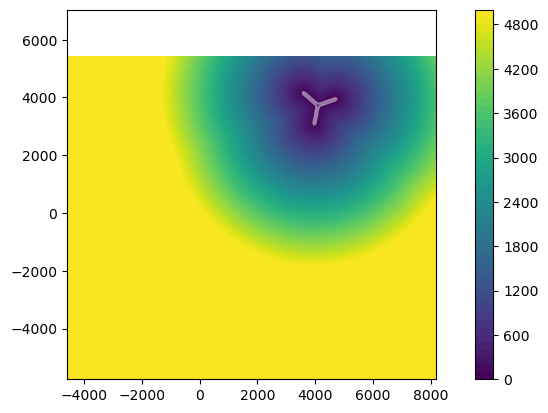

In [9]:
xA = -1.0
yA = 0.0
xB = 1.0
yB = 1.0

X, Y = np.meshgrid(
    # np.linspace(-3.0, 3.0, 201),
    # np.linspace(-3.0, 3.0, 201),
    np.linspace(
        np.min(P_moorings[:, :, 0]) - 1250.0, np.max(P_moorings[:, :, 0]) + 1250.0, 201
    ),
    np.linspace(
        np.min(P_moorings[:, :, 1]) - 1250.0, np.max(P_moorings[:, :, 1]) + 1250.0, 201
    ),
)
D = np.zeros_like(X)
D_pure = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        # D[i,j] = distance_point_to_lineseg(X[i,j], Y[i,j], xA, yA, xB, yB)
        # D[i,j] = distance_point_to_mooring(X[i,j], Y[i,j], P_moorings[0,:,:], D_ref=None)
        D[i, j] = distance_point_to_mooring(
            X[i, j], Y[i, j], P_moorings[0, :, :], D_ref=1000.0
        )
        D_pure[i, j] = distance_point_to_mooring(
            X[i, j], Y[i, j], P_moorings[0, :, :], D_ref=None
        )
plt.contourf(X, Y, D, levels=51)
plt.colorbar()
plt.contour(X, Y, D, levels=[50.0], colors="w", alpha=0.5)
# plt.plot([xA, xB], [yA, yB], ".-k")
plt.axis("square");

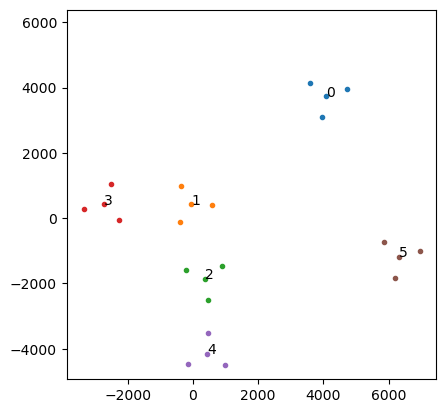

In [11]:
for i_turb in range(P_moorings.shape[0]):
    plt.text(P_turbines[i_turb, 0], P_turbines[i_turb, 1], i_turb)
    plt.plot(P_moorings[i_turb, :, 0], P_moorings[i_turb, :, 1], ".")
plt.axis("square");

In [13]:
for i in [
    2,
]:  # range(P_moorings.shape[0]):
    for j in range(P_moorings.shape[0]):
        if i == j:
            continue
        print(
            i,
            j,
            distance_mooring_to_mooring(
                P_moorings[i, :, :], P_moorings[j, :, :], D_ref=1000.0
            ),
        )

2 0 4999.9949999906075
2 1 1504.1851804148857
2 3 2593.3071144439336
2 4 1042.8521242812467
2 5 4999.856946542836
